# **Develop Regression Models for Soil Properties Estimation**

In [1]:
import os

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from sklearn import preprocessing
import tensorflow as tf
import tensorflow_probability as tfp

### Load data

In [2]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/data'

ntb_data_path = os.path.join(DATA_DIR, 'NTB_black_data.csv')
tb_data_path = os.path.join(DATA_DIR, 'TB_blue_data.csv')

ntb_data= pd.read_csv(ntb_data_path)
tb_data = pd.read_csv(tb_data_path)

### Data pre-processing

In [3]:
# Specific soil types
assign_num_list = {'uncertain': 9,
                    'topsoil layer': 8,
                    'reclaimed layer': 7,
                    'sedimentary layer': 6,
                    'colluvial layer': 5,
                    'weathered soil': 4,
                    'weathered rock': 3,
                    'soft rock': 2,
                    'moderate rock': 1,
                     'hard rock': 0,
                  }

In [4]:
ntb_names = ntb_data['Soi properties (main)']
tb_names = tb_data['Soi properties (main)']

ntb_target = ntb_names.replace(assign_num_list)
tb_target = tb_names.replace(assign_num_list)

ntb_data['Target'] = ntb_target
tb_data['Target'] = tb_target

X_train_ntb = ntb_data[['X','Y','Elevation']].to_numpy()
y_train_ntb = ntb_data['Target'].to_numpy()

X_train_tb = tb_data[['X','Y','Elevation']].to_numpy()
y_train_tb = tb_data['Target'].to_numpy()

# https://scikit-learn.org/stable/modules/preprocessing.html
normalizer = preprocessing.MinMaxScaler()

normalized_X_train_ntb = normalizer.fit_transform(X_train_ntb)
normalized_X_train_tb = normalizer.fit_transform(X_train_tb)

# merge NTB and TB
X_train_merged_ntb_tb = np.concatenate((X_train_ntb, X_train_tb), axis=0)
normalized_X_merged_ntb_tb = np.concatenate((normalized_X_train_ntb, normalized_X_train_tb), axis=0)
y_train_merged_ntb_tb = np.concatenate((y_train_ntb, y_train_tb), axis=0)


In [5]:
ntb_data

,Name,X,Y,Elevation,Soi properties (main),Unnamed: 5,Update evlevation,Elevation past,Target
0,NTB-1,549723.89,213802.88,128.5,reclaimed layer,NaN,128.5,28.5,7
1,NTB-1,549723.89,213802.88,126.0,sedimentary layer,NaN,126.0,26.0,6
2,NTB-1,549723.89,213802.88,121.5,weathered soil,NaN,121.5,21.5,4
3,NTB-1,549723.89,213802.88,107.7,weathered rock,NaN,107.7,7.7,3
4,NTB-1,549723.89,213802.88,99.7,soft rock,NaN,99.7,-0.3,2
...,...,...,...,...,...,...,...,...,...
91,NTB-12,549564.60,213804.70,114.5,weathered rock,NaN,114.5,14.5,3
92,NTB-12,549564.60,213804.70,107.5,moderate rock,NaN,107.5,7.5,1
93,NTB-12,549564.60,213804.70,89.5,hard rock,NaN,89.5,-10.5,0
94,NTB-12,549564.60,213804.70,86.5,moderate rock,NaN,86.5,-13.5,1


In [6]:
tb_data

,Name,X,Y,Elevation,Soi properties (main),Target
0,TB-1,549699.0411,213765.3279,128.60,reclaimed layer,7
1,TB-1,549699.0411,213765.3279,126.60,sedimentary layer,6
2,TB-1,549699.0411,213765.3279,117.60,weathered soil,4
3,TB-1,549699.0411,213765.3279,108.10,weathered rock,3
4,TB-1,549699.0411,213765.3279,94.60,soft rock,2
...,...,...,...,...,...,...
111,TB-22,550622.5600,213730.7000,134.49,reclaimed layer,7
112,TB-22,550622.5600,213730.7000,114.19,weathered soil,4
113,TB-22,550622.5600,213730.7000,104.19,weathered rock,3
114,TB-22,550622.5600,213730.7000,93.69,soft rock,2


# Deterministic Models

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Deep regression neural network 

In [8]:
def create_model(dim):
    model = Sequential([
        Dense(10, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(10, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(10, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(1, kernel_initializer='normal', activation='linear')
    ])
    
    model.compile(loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(learning_rate=0.001))
    
    model.summary()
    return model

### Customized callbacks

In [9]:
def get_checkpoint_best_only(model_type = 'deterministic', train_data = 'ntb'):
    current_dir = os.getcwd()
    if model_type:
        checkpoint_path = current_dir + "/checkpoints_best_only_{}_{}/checkpoint".format(model_type, train_data)

    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                frequency = "epoch",
                                save_weights_only = True,
                                monitor = "mean_squared_error",
                                save_best_ony = True,
                                verbose = 1)
    return checkpoint

In [10]:
def get_early_stopping():
    early_stopping = EarlyStopping(monitor = "loss", mode ="min", patience = 5)
    return early_stopping 
    

In [11]:
checkpoint_best_only = get_checkpoint_best_only(model_type = 'deterministic', train_data = 'ntb')
early_stopping = get_early_stopping()

In [12]:
callbacks = [checkpoint_best_only, early_stopping]

In [13]:
model = create_model(dim = 3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


### **Train on NTB**

In [14]:
%%time
hist = model.fit(normalized_X_train_ntb, y_train_ntb, 
                epochs = 250, verbose=1,
                batch_size=16,
                callbacks=callbacks)
#                 validation_data=(normalized_X_train_tb,y_train_tb))

Epoch 1/250
6/6 [==============================] - 1s 2ms/step - loss: 16.1691

Epoch 00001: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_ntb/checkpoint
Epoch 2/250
6/6 [==============================] - 0s 2ms/step - loss: 17.4636

Epoch 00002: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_ntb/checkpoint
Epoch 3/250
6/6 [==============================] - 0s 1ms/step - loss: 14.2969

Epoch 00003: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_ntb/checkpoint
Epoch 4/250
6/6 [==============================] - 0s 2ms/step - loss: 14.4660

Epoch 00004: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_ntb/checkpoint
Epoch 5/250
6/6 [==============================] - 0s 1ms/step - loss: 14.5000

Epoch 00005: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_ntb/c

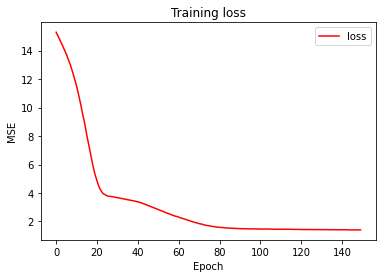

In [15]:
plt.plot(hist.history['loss'],'r',label='loss')
# plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()


### **Train on TB**

In [16]:
model = create_model(dim = 3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [17]:
checkpoint_best_only = get_checkpoint_best_only(model_type = 'deterministic', train_data = 'tb')
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [18]:
%%time
hist = model.fit(normalized_X_train_tb, y_train_tb, 
                epochs = 250, verbose=1,
                batch_size=16,
                callbacks=callbacks)
#                 validation_data=(normalized_X_train_tb,y_train_tb))

Epoch 1/250
8/8 [==============================] - 0s 1ms/step - loss: 18.0616

Epoch 00001: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_tb/checkpoint
Epoch 2/250
8/8 [==============================] - 0s 2ms/step - loss: 17.3166

Epoch 00002: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_tb/checkpoint
Epoch 3/250
8/8 [==============================] - 0s 2ms/step - loss: 16.5492

Epoch 00003: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_tb/checkpoint
Epoch 4/250
8/8 [==============================] - 0s 1ms/step - loss: 14.5821

Epoch 00004: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_tb/checkpoint
Epoch 5/250
8/8 [==============================] - 0s 2ms/step - loss: 15.5805

Epoch 00005: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_tb/checkp

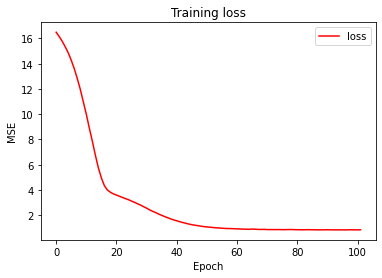

In [19]:
plt.plot(hist.history['loss'],'r',label='loss')
# plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

### **Train on merged NTB and TB**

In [20]:
model = create_model(dim = 3)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [21]:
checkpoint_best_only = get_checkpoint_best_only(model_type = 'deterministic', train_data = 'merged_ntb_tb')
early_stopping = get_early_stopping()
callbacks = [checkpoint_best_only, early_stopping]

In [22]:
%%time
hist = model.fit(normalized_X_merged_ntb_tb, y_train_merged_ntb_tb, 
                epochs = 250, verbose=1,
                batch_size=16,
                callbacks=callbacks)
#                 validation_data=(normalized_X_train_tb,y_train_tb))

Epoch 1/250
14/14 [==============================] - 0s 2ms/step - loss: 18.8914

Epoch 00001: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_merged_ntb_tb/checkpoint
Epoch 2/250
14/14 [==============================] - 0s 2ms/step - loss: 16.5511

Epoch 00002: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_merged_ntb_tb/checkpoint
Epoch 3/250
14/14 [==============================] - 0s 2ms/step - loss: 16.8643

Epoch 00003: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_merged_ntb_tb/checkpoint
Epoch 4/250
14/14 [==============================] - 0s 1ms/step - loss: 13.5185

Epoch 00004: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_deterministic_merged_ntb_tb/checkpoint
Epoch 5/250
14/14 [==============================] - 0s 3ms/step - loss: 16.1883

Epoch 00005: saving model to /home/daitran/Desktop/git/soil_pr

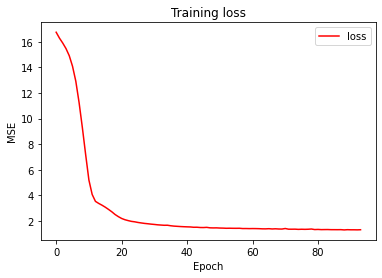

In [23]:
plt.plot(hist.history['loss'],'r',label='loss')
# plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Probabilistic models

In the deterministic models, we develop ANN's weights with a single value. However, the true value of this weight is not certion. Because we have too little data points, therefor the training data contains its uncertainty. So, we have to develop the model that can handle the uncertainty in deep learning models. This is done by changing each weight from a single deterministic value to a probability distribution.

### Baysian Neural Network

In [24]:
tfd = tfp.distributions
tfpl = tfp.layers

In [25]:
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t : tfd.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag = tf.ones(n))
        )
    ])
    return prior_model

In [26]:
def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype = dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

In [27]:
model_prob = Sequential([
    tfpl.DenseVariational(units=20,
                          input_shape=(3,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/normalized_X_train_ntb.shape[0],
                          activation='relu'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/normalized_X_train_ntb.shape[0]),
    tfpl.IndependentNormal(1)
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.


In [28]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_prob.compile(loss=nll, optimizer=tf.optimizers.Adam(learning_rate=0.001))
model_prob.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 20)                3320      
_________________________________________________________________
dense_variational_1 (DenseVa (None, 2)                 945       
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 4,265
Trainable params: 4,265
Non-trainable params: 0
_________________________________________________________________


In [29]:
normalized_X_train_ntb_d =  tf.constant(normalized_X_train_ntb, dtype=tf.float64)

In [30]:
# tf.dtypes.cast(normalized_X_train_ntb_d, tf.float64)

In [31]:
y_train_ntb_d =  tf.constant(y_train_ntb, dtype=tf.float64)

In [32]:
# tf.dtypes.cast(y_train_ntb_d, tf.float64)

In [33]:
tf.config.run_functions_eagerly(True)

In [34]:
checkpoint_best_only = get_checkpoint_best_only(model_type = 'probabilistic')
callbacks_prob = [checkpoint_best_only]

### Train

In [35]:
his_prob = model_prob.fit(normalized_X_train_ntb_d, y_train_ntb_d,
                     epochs=100, verbose=1,
#                      batch_size = 10,
                     callbacks=callbacks_prob
                         )

/home/daitran/miniconda3/envs/probability/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/100
3/3 [==============================] - 1s 112ms/step - loss: 422.8582

Epoch 00001: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_probabilistic_ntb/checkpoint
Epoch 2/100
3/3 [==============================] - 0s 111ms/step - loss: 1858.8403

Epoch 00002: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_probabilistic_ntb/checkpoint
Epoch 3/100
3/3 [==============================] - 0s 108ms/step - loss: 17066.5739

Epoch 00003: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_probabilistic_ntb/checkpoint
Epoch 4/100
3/3 [==============================] - 0s 108ms/step - loss: 12.0267

Epoch 00004: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_probabilistic_ntb/checkpoint
Epoch 5/100
3/3 [==============================] - 0s 125ms/step - loss: 1039.7761

Epoch 00005: saving model to /home/daitran/Desktop/git/soil_properties/checkpoints_best_only_p

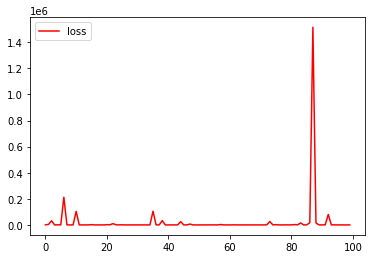

In [36]:
plt.plot(his_prob.history['loss'],'r',label='loss')
# plt.plot(hist.history['val_loss'],'b',label='val_loss')
plt.legend()
plt.show()


## **Predict**

In [37]:
def get_model_best_epoch(model, model_type, train_data = 'ntb'):
    current_dir = os.getcwd()
    if model_type:
        checkpoint_path = current_dir + "/checkpoints_best_only_{}_{}/checkpoint".format(model_type, train_data)
    
    model.load_weights(checkpoint_path)
    
    return model

In [38]:
def plot_data(x, y, labels, colours):
    
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(20, 10))
    
    ax = fig.add_subplot(121, projection='3d')

    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
    ax = fig.add_subplot(122, projection='3d')
    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        ax.view_init(90, 0)   
        
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

In [39]:
labels = {}
for k, v in assign_num_list.items():
    labels[v] = k

In [40]:
label_colours = ['black', 'brown', 'red', 'magenta',
                'pink', 'yellow', 'green',
                'blue','cyan','silver']

# label_colours = ['blue', 'green', 'red', 'cyan',
#                  'magenta', 'yellow', 'black', 'brown', 
#                  'pink','silver']

# **Ground truth**

### **NTB**

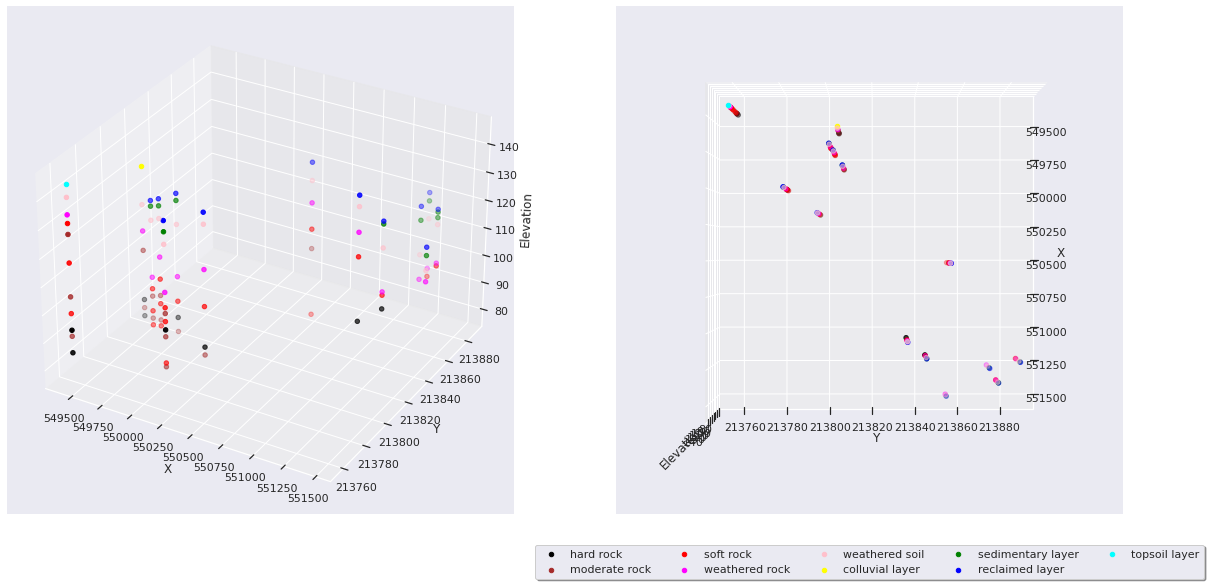

In [41]:
plot_data(X_train_ntb, y_train_ntb, labels, label_colours)
plt.show()

### **TB**

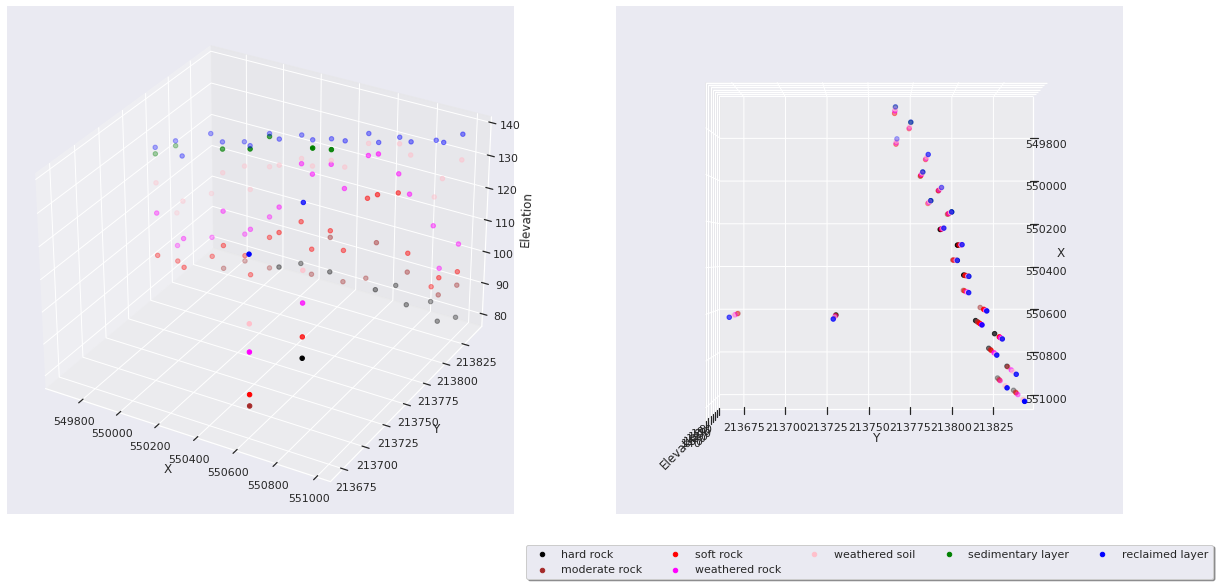

In [42]:
plot_data(X_train_tb, y_train_tb, labels, label_colours)
plt.show()

### **Merged NTB and TB**

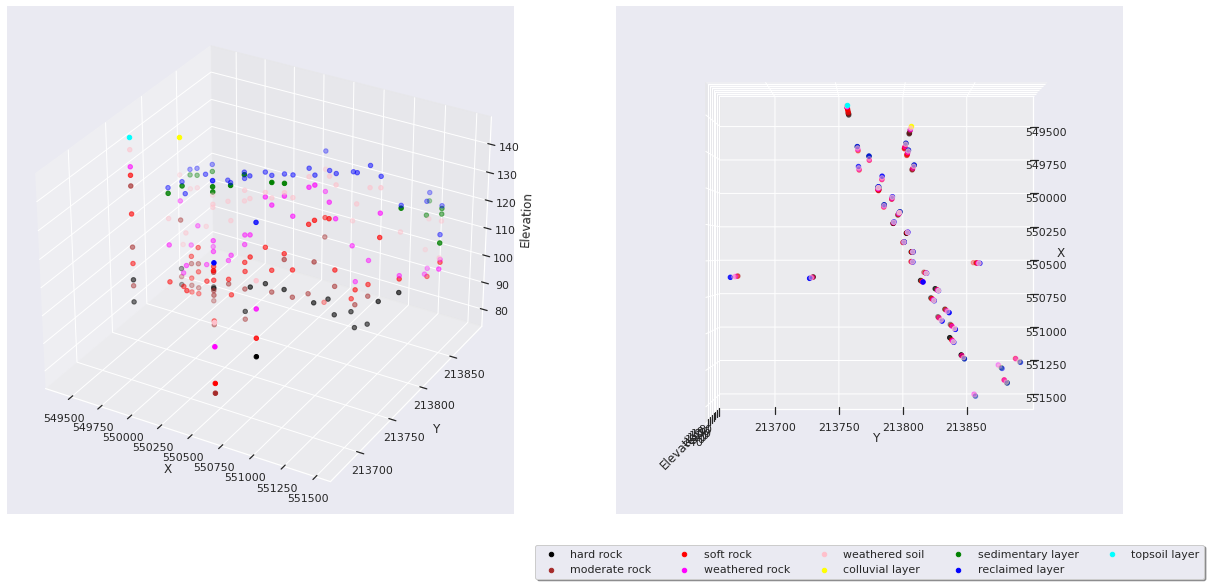

In [43]:
plot_data(X_train_merged_ntb_tb, y_train_merged_ntb_tb, labels, label_colours)
plt.show()

# **Deterministic model results**

## **Train on NTB results**

In [44]:
model_best = get_model_best_epoch(model, model_type = 'deterministic', train_data ='ntb')

In [45]:
y_predict = np.around(model_best.predict(normalized_X_train_ntb)).astype(int)
y_predict[y_predict < 0] = 0
y_predict[y_predict > 8] = 8

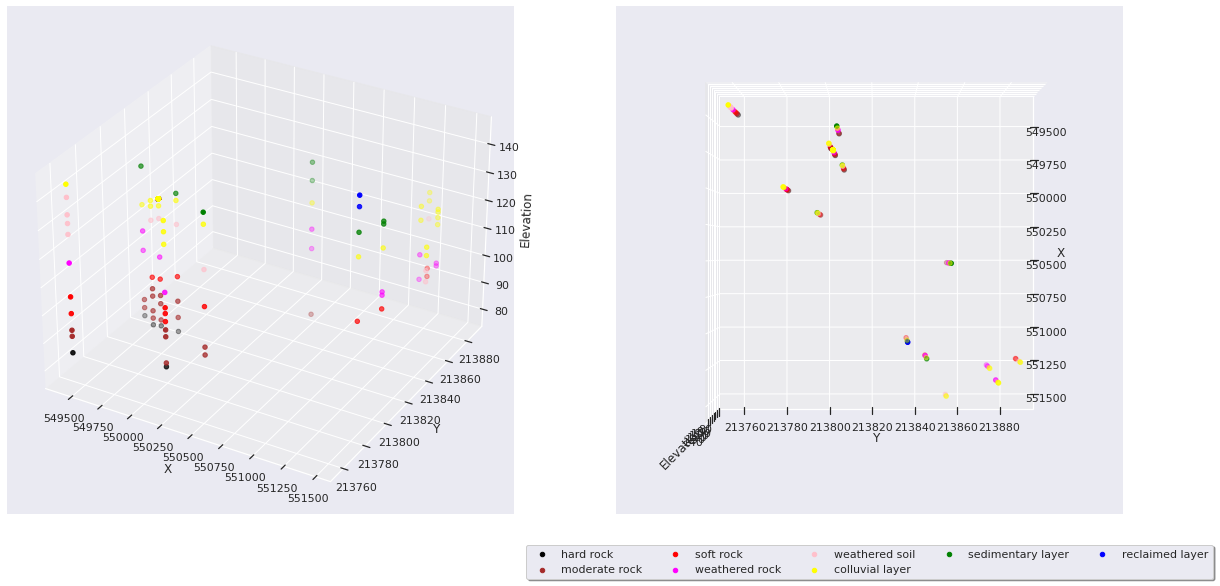

In [46]:
plot_data(X_train_ntb, y_predict, labels, label_colours)
plt.show()

## **Train on TB results**

In [47]:
model_best = get_model_best_epoch(model, model_type = 'deterministic', train_data ='tb')

In [48]:
y_predict = np.around(model_best.predict(normalized_X_train_tb)).astype(int)
y_predict[y_predict < 0] = 0
y_predict[y_predict > 8] = 8

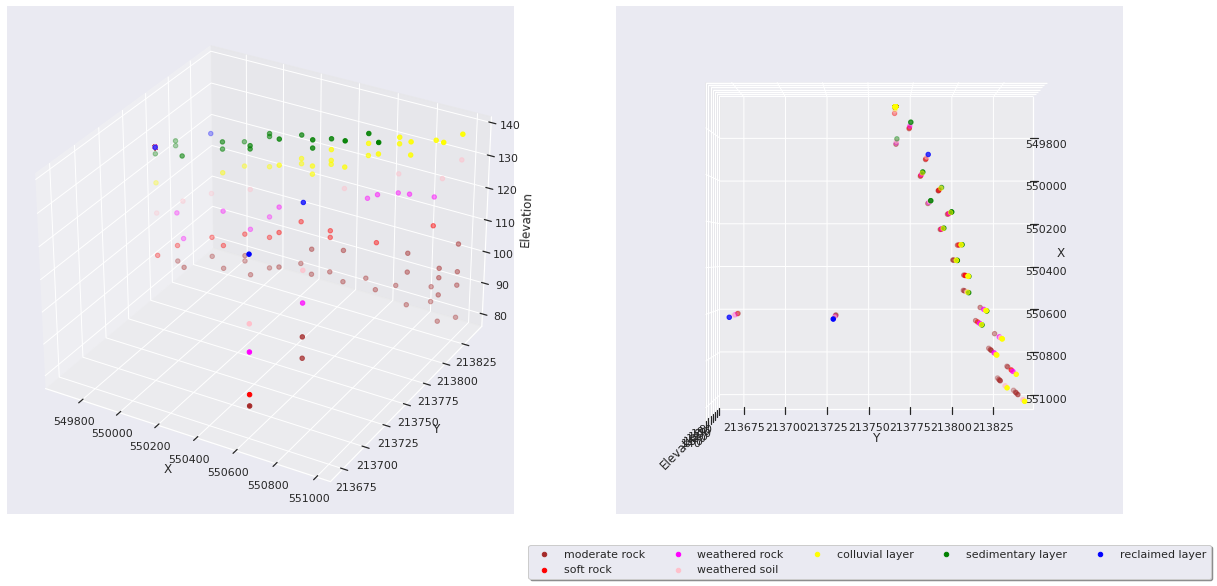

In [49]:
plot_data(X_train_tb, y_predict, labels, label_colours)
plt.show()

## **Train on merged NTB and TB results**

In [50]:
model_best = get_model_best_epoch(model, model_type = 'deterministic', train_data ='merged_ntb_tb')

In [51]:
y_predict = np.around(model_best.predict(normalized_X_merged_ntb_tb)).astype(int)
y_predict[y_predict < 0] = 0
y_predict[y_predict > 8] = 8

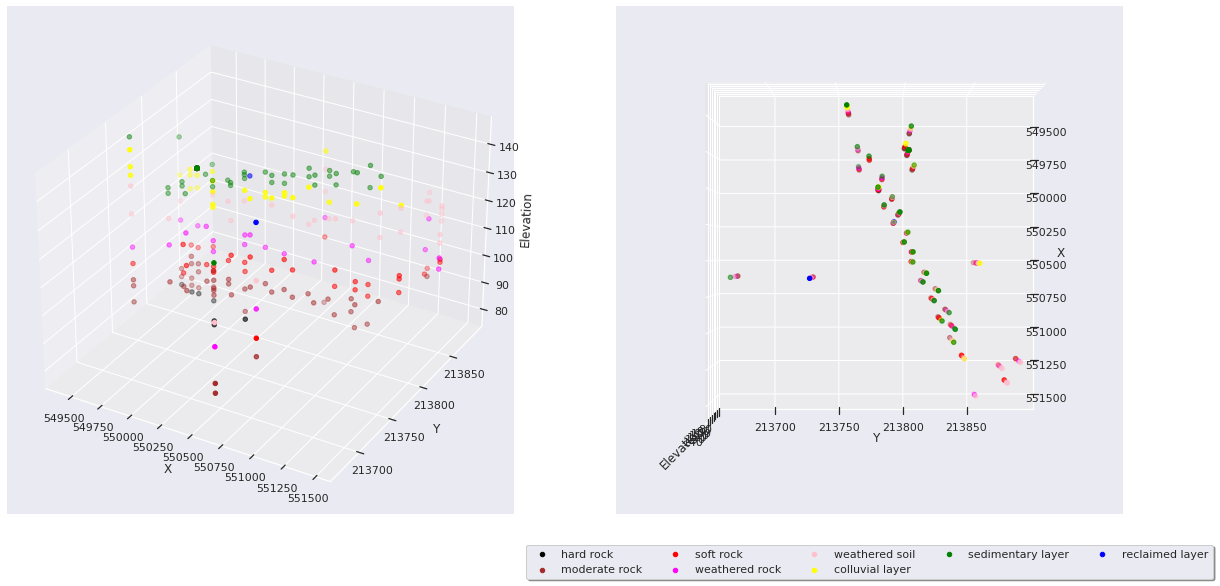

In [52]:
plot_data(X_train_merged_ntb_tb, y_predict, labels, label_colours)
plt.show()

# **Probabilistic model results**

In [53]:
model_best = get_model_best_epoch(model_prob, model_type = 'probabilistic')
# model_best = get_model_best_epoch(model, model_type = 'deterministic')

In [54]:
y_predict = np.around(model_best.predict(normalized_X_train_ntb)).astype(int)
y_predict[y_predict < 0] = 0
y_predict[y_predict > 8] = 8

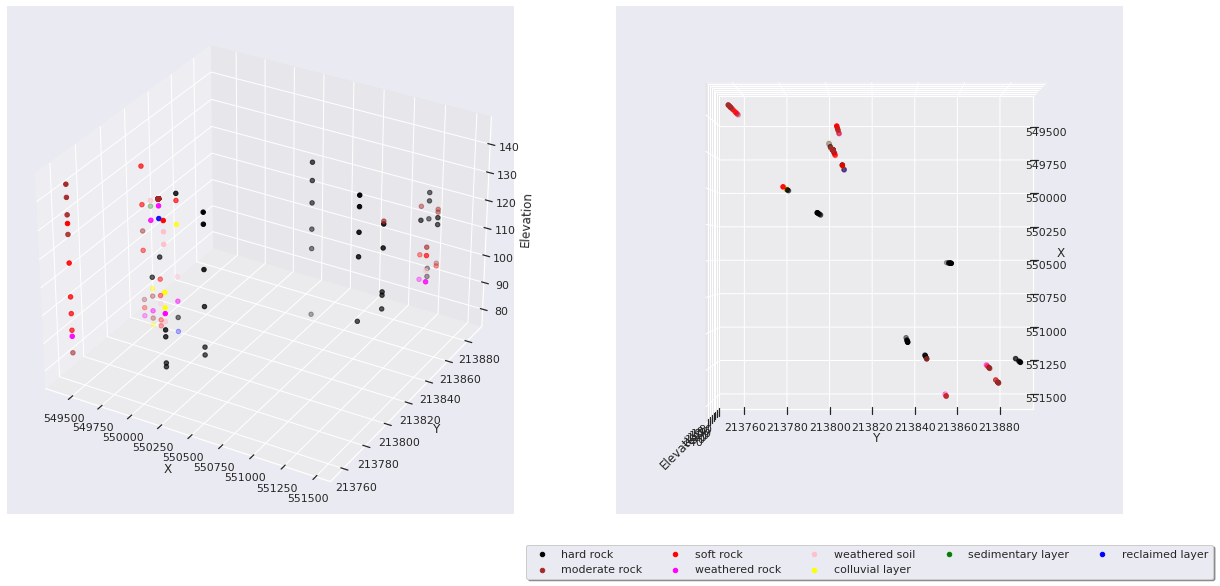

In [55]:
plot_data(X_train_ntb, y_predict, labels, label_colours)
plt.show()